# Introduction

TODO


# Imports

In [2]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import re
%matplotlib inline

/home/ahmad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue             
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index].strip() + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [117]:
def generate_data_with_noise(all_texts, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for rev in all_texts:
            sents = sent_tokenize(rev) # Get review sentences.
            #print(len(sents))
            sent = sents[np.random.randint(0, max(1, len(sents) - 1))] # Pick some random sentence.
            if cnt < num_samples :                
                   
                input_text = noise_maker(sent, noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sent.strip() + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                 
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1].strip() + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_words_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:       
        for word in word_tokenize(sentence):
            word = process_word(word)
            if word not in vocab_to_int:
                vocab_to_int[word] = count
                count += 1


    '''''Build inverse translation from int to word'''
    int_to_vocab = {}
    for word, value in vocab_to_int.items():
        int_to_vocab[value] = word
        
    return vocab_to_int, int_to_vocab

In [10]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [103]:
def vectorize_char_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        if len(input_text) > max_encoder_seq_length or len(target_text) > max_encoder_seq_length:
            continue
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [48]:
def vectorize_words_data(input_texts, target_texts, max_words_seq_length, max_chars_seq_length, num_char_tokens, num_word_tokens, word2int, char2int):

    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    # 
    encoder_char_input_data = np.zeros(
    (len(input_texts), max_words_seq_length, max_chars_seq_length),
    dtype='float32')
    
    decoder_word_input_data = np.zeros(
        (len(input_texts), max_words_seq_length),
        dtype='float32')
    
    decoder_word_target_data = np.zeros(
        (len(input_texts), max_words_seq_length, num_word_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        words_lst = word_tokenize(input_text)
        if(len(words_lst) > max_words_seq_length):
            continue
        for j, word in enumerate(words_lst):
            if(len(word) > max_chars_seq_length):
                continue
            for k, char in enumerate(word):
                # c0..cn
                if(char in char2int):
                    encoder_char_input_data[i, j, k] = char2int[char]
                    
        words_lst = word_tokenize(target_text)# word_tokenize removes the \t and \n, we need them to start and end a sequence
        words_lst.insert(0, '\t')
        words_lst.append('\n')        
        if(len(words_lst) > max_words_seq_length):
            continue                
        for j, word in enumerate(words_lst):
            processed_word = process_word(word)
            if not processed_word in word2int:
                continue
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_word_input_data[i, j] = word2int[processed_word]
            if j > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_word_target_data[i, j - 1, word2int[processed_word]] = 1.
                
    return encoder_char_input_data, decoder_word_input_data, decoder_word_target_data

In [150]:
def vectorize_sentences_data(input_texts, target_labels, max_sents_per_doc, max_words_per_sent, max_chars_per_word, 
                             num_classes, char2int):

    
    
    hier_input_data = np.zeros((len(input_texts), 
                                max_sents_per_doc, 
                                max_words_per_sent, 
                                max_chars_per_word), dtype='float32')
    
        
    hier_target_data = np.zeros((len(input_texts), num_classes), dtype='float32')

    
    for i, (input_text, target_label) in enumerate(zip(input_texts, target_labels)):
        #sents_lst = sent_tokenize(clean_str(BeautifulSoup(input_text).get_text())) # TODO: Move to clean str
        sents_lst = sent_tokenize(input_text)
        
        
        if len(sents_lst) > max_sents_per_doc:
            continue
        
        for j, sent in enumerate(sents_lst):
                
            words_lst = word_tokenize(input_text)
            
            if(len(words_lst) > max_words_per_sent):
                continue
            
            
            for k, word in enumerate(words_lst):
                
                
                if(len(word) > max_chars_per_word):
                    continue
                
                for l, char in enumerate(word):
                    # c0..cn
                    if(char in char2int):
                        hier_input_data[i, j, k, l] = char2int[char]
                        hier_target_data[i, target_label] = 1

                
    return hier_input_data, hier_target_data

In [14]:
def decode_gt_sequence(input_seq, int_to_vocab):

    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_word = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_word + ' '

    return decoded_sentence

In [15]:
def decode_words_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_words_seq_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []

    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    i = 0
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
       
        
        #orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(word_tokenize(decoded_sentence)) > max_words_seq_len):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        '''
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        '''
        decoded_sentence += sampled_char + ' '


        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1, max_words_seq_len))
        if i < max_words_seq_len:
            target_seq[0, i] = sampled_token_index

        # Update states
        states_value = [h, c]
        i += 1
        #if i > 48:
        #    i = 0
        

    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [16]:
def decode_char_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_encoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [3]:
def build_chars2word_model_simple_BiLSTM(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
 
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    return encoder_word_embedding_model

In [20]:
def build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                           max_words_seq_len, 
                           max_char_seq_len, 
                           num_word_tokens, 
                           num_char_tokens, 
                           latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    #print(inputs.shape)
    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, char_vocab_size))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
        
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_sentence_embedding_model = Model(input=inputs, output=encoder_embedding_output)

    return encoder_sentence_embedding_model

In [17]:
def build_chars2word_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    #print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    #print(decoder_outputs)
    #print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_encoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    #print('encoder-decoder  model:')
    print(model.summary()) 
    
    #print(encoder_inputs)
    #print(encoder_outputs)
    #print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)
    #print(encoder_outputs.shape)
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model, encoder_word_embedding_model

In [5]:
def build_words2sent_model(encoder_word_embedding_model, 
                           max_words_seq_len, 
                           max_char_seq_len, 
                           num_word_tokens, 
                           num_char_tokens, 
                           latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    decoder_inputs_words = Input(shape=(max_words_seq_len,), dtype='float32')
    words_states = []
    '''
    for w in range(max_words_seq_len):
        
        encoder_char_inputs = Lambda(lambda x: x[:,w,:])(inputs)
        _, h, c = encoder_char_model(encoder_char_inputs)
        encoder_chars_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        encoder_chars_states = Reshape((1,latent_dim*4))(encoder_chars_states)
        words_states.append(encoder_chars_states)
    
    input_words = Concatenate(axis=-2)(words_states)

    '''
    #input_words = TimeDistributed(Dense(10))(inputs)

    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, char_vocab_size))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    
    decoder_inputs = decoder_inputs_words
    decoder_inputs_ = Embedding(num_word_tokens, latent_dim*4,                           
                            #weights=[np.eye(num_word_tokens)],
                            mask_zero=True, trainable=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_word_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([inputs, decoder_inputs_words], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=inputs, output=[encoder_outputs] + encoder_states)
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_sentence_embedding_model = Model(input=inputs, output=encoder_embedding_output)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(max_words_seq_len, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs_words, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model, encoder_sentence_embedding_model

In [39]:
 
def build_sent2doc_model(encoder_word_embedding_model, #? Already inside encoder_sentence_embedding_model?
                         encoder_sentence_embedding_model, 
                         max_sents_seq_len, 
                         max_words_seq_len, 
                         max_char_seq_len, 
                         char2word_latent_dim,#?
                         word2sent_latent_dim,
                         sent2doc_latent_dim):
    
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    
    sents_states = []
    
    for s in range(max_sents_seq_len):
        
        encoder_words_inputs = Lambda(lambda x: x[:,s,:,:])(inputs)
        #print(encoder_words_inputs.shape)
        encoder_words_outputs = encoder_sentence_embedding_model(encoder_words_inputs)
        encoder_words_outputs = Reshape((1,word2sent_latent_dim*2))(encoder_words_outputs)
        #_, h, c = encoder_sentence_embedding_model(encoder_words_inputs)
        '''
        input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

        encoder_inputs_ = input_words   
        #encoder_inputs = Input(shape=(None, char_vocab_size))
        encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
        encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM

        encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
        '''
        
        
        #encoder_words_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        #encoder_words_states = Reshape((1,word2sent_latent_dim*4))(encoder_words_states)
        print(encoder_words_outputs.shape)
        sents_states.append(encoder_words_outputs)
    #print(sents_states)
    input_sents = Concatenate(axis=-2)(sents_states)
    print(input_sents.shape)
    encoder_inputs_ = input_sents   
    encoder = Bidirectional(LSTM(sent2doc_latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM
    
    return encoder

In [ ]:
char2word_latent_dim = 512
word2sent_latent_dim = 256
sent2doc_latent_dim = 128
char_vocab_size = 28
word_vocab_size = 10000
MAX_SENTS_PER_DOC = 11
MAX_WORDS_PER_SENT = 24
MAX_CHARS_PER_WORD = 5
#_, _, _, encoder_word_embedding_model = build_chars2word_model(num_encoder_tokens=char_vocab_size, latent_dim=chars2word_latent_dim)
encoder_word_embedding_model = build_chars2word_model_simple_BiLSTM(num_encoder_tokens=char_vocab_size, latent_dim=char2word_latent_dim)
print(encoder_word_embedding_model.summary())
'''
_, _, _, encoder_sentence_embedding_model = build_words2sent_model(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                                   num_word_tokens=word_vocab_size, 
                                                                   num_char_tokens=char_vocab_size, 
                                                                   latent_dim=words2sent_latent_dim)
'''
encoder_sentence_embedding_model = build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                                   num_word_tokens=word_vocab_size, 
                                                                   num_char_tokens=char_vocab_size, 
                                                                   latent_dim=word2sent_latent_dim)
print(encoder_sentence_embedding_model.summary())

encoder_review_embedding = build_sent2doc_model(encoder_word_embedding_model, #? Already inside encoder_sentence_embedding_model?
                                                 encoder_sentence_embedding_model, 
                                                 max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                                 max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                 max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                 char2word_latent_dim=char2word_latent_dim,#?
                                                 word2sent_latent_dim=word2sent_latent_dim,
                                                 sent2doc_latent_dim=sent2doc_latent_dim)
print(encoder_review_embedding.summary())


/home/ahmad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 28)          784       
_________________________________________________________________
bidirectional_36 (Bidirectio [(None, None, 1024), (Non 2215936   
_________________________________________________________________
lambda_103 (Lambda)          (None, 1024)              0         
Total params: 2,216,720
Trainable params: 2,215,936
Non-trainable params: 784
_________________________________________________________________
None
(?, 24, 5)


/home/ahmad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 24, 5)             0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 24, 1024)          2216720   
_________________________________________________________________
bidirectional_37 (Bidirectio [(None, 24, 512), (None,  2623488   
_________________________________________________________________
lambda_104 (Lambda)          (None, 512)               0         
Total params: 4,840,208
Trainable params: 4,839,424
Non-trainable params: 784
_________________________________________________________________
None
(?, 1, 512)
(?, 1, 512)
(?, 1, 512)
(?, 1, 512)
(?, 1, 512)
(?, 1, 512)
(?, 1, 512)
(?, 1, 512)


In [19]:

def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_words_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

In [20]:
def process_word(word):
    # Try to correct the word from known dict
    #word = spell(word)
    # Option 1: Replace special chars and digits
    #processed_word = re.sub(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', r'', w.lower())
    
    # Option 2: skip all words with special chars or digits
    if(len(re.findall(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', word.lower())) == 0):
        #processed_word = word.lower()
        processed_word = word
    else:
        processed_word = 'UNK'

    # Skip stop words
    #stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]        
    stop_words = []
    if processed_word in stop_words:
        processed_word = 'UNK'
        
    return processed_word


In [21]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

# Pre-train char model

## Load data

In [22]:
'''
data_path = '../../dat/'
max_sent_len = 50
min_sent_len = 0
'''

"\ndata_path = '../../dat/'\nmax_sent_len = 50\nmin_sent_len = 0\n"

In [23]:
'''
num_samples = 1000
input_texts = []
target_texts = []
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_noise(tess_correction_data, num_file_samples, noise_threshold, max_sent_len, min_sent_len)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

'''    

"\nnum_samples = 1000\ninput_texts = []\ntarget_texts = []\nfiles_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']\ndesired_file_sizes = [num_samples, num_samples, num_samples, num_samples]\nnoise_threshold = 0.9\n\nfor file_name, num_file_samples in zip(files_list, desired_file_sizes):\n    tess_correction_data = os.path.join(data_path, file_name)\n    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_noise(tess_correction_data, num_file_samples, noise_threshold, max_sent_len, min_sent_len)\n\n    input_texts += input_texts_OCR\n    target_texts += target_texts_OCR\n\n"

In [24]:
#len(input_texts)

In [25]:
data_path = '../../dat/'
data_file = 'imdb/labeledTrainData.tsv'

In [26]:
data_train = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_train.shape)
data_train.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [27]:
'''
for text in data_train.review:
    for sent in sent_tokenize(clean_str(BeautifulSoup(text).get_text())):
        print(sent + '\n')
        for word in word_tokenize(sent):
            print(word + '\n')
    print('****************\n')
'''

"\nfor text in data_train.review:\n    for sent in sent_tokenize(clean_str(BeautifulSoup(text).get_text())):\n        print(sent + '\n')\n        for word in word_tokenize(sent):\n            print(word + '\n')\n    print('****************\n')\n"

In [ ]:
data_train.review

### Histogram of lenghts

In [28]:

chars_per_words_lengths = []
words_per_sents_lengths = []
sents_per_docs_lengths = []

# Chars per word should be on all text
for text in data_train.review:
    
    sents = sent_tokenize(clean_str(BeautifulSoup(text).get_text()))
    sents_per_docs_lengths.append(len(sents))
    for sent in sents:       
    
        words = word_tokenize(text)
        words_per_sents_lengths.append(len(words))
        for word in words:
            chars_per_words_lengths.append(len(word))

    

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


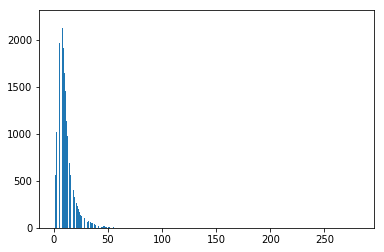

In [29]:
h_s = plt.hist(sents_per_docs_lengths, bins=500)

In [39]:
np.mean(sents_per_docs_lengths)

10.700519999999999

In [40]:
np.max(sents_per_docs_lengths)

282

In [45]:
np.std(sents_per_docs_lengths)

8.1049387246048941

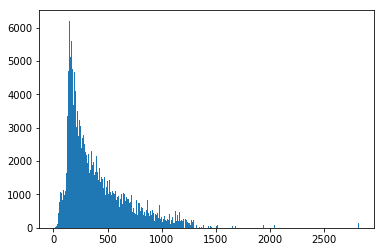

In [30]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

In [38]:
np.mean(words_per_sents_lengths)

23.985993204068588

In [41]:
np.max(words_per_sents_lengths)

936

In [44]:
np.std(words_per_sents_lengths)

19.567778477735885

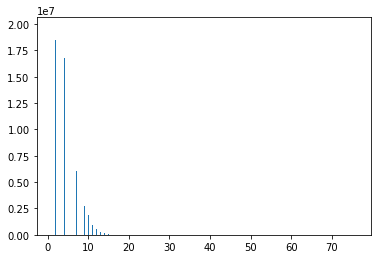

In [31]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

In [37]:
np.mean(chars_per_words_lengths)

4.1450829220930512

In [42]:
np.max(chars_per_words_lengths)

80

In [43]:
np.std(chars_per_words_lengths)

2.5863593461489964

In [155]:
all_texts = list(data_train.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


## Build char vocab (all text)

In [156]:

vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
#np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

In [157]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in all_texts])

In [158]:
print('Number of samples:', len(all_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)


Number of samples: 25000
Number of unique input tokens: 142
Number of unique output tokens: 142
Max sequence length for inputs: 13546


In [87]:
char2int

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 37,
 '#': 68,
 '$': 57,
 '%': 59,
 '&': 56,
 '(': 35,
 ')': 36,
 '*': 54,
 '+': 71,
 ',': 23,
 '-': 39,
 '.': 27,
 '/': 49,
 '0': 31,
 '1': 41,
 '2': 30,
 '3': 53,
 '4': 48,
 '5': 45,
 '6': 42,
 '7': 50,
 '8': 46,
 '9': 44,
 ':': 40,
 ';': 43,
 '<': 97,
 '=': 58,
 '>': 91,
 '?': 34,
 '@': 67,
 'UNK': 0,
 '[': 62,
 ']': 63,
 '^': 82,
 '_': 69,
 '`': 55,
 'a': 8,
 'b': 28,
 'c': 22,
 'd': 16,
 'e': 17,
 'f': 12,
 'g': 13,
 'h': 7,
 'i': 5,
 'j': 19,
 'k': 26,
 'l': 9,
 'm': 18,
 'n': 15,
 'o': 14,
 'p': 29,
 'q': 33,
 'r': 21,
 's': 10,
 't': 6,
 'u': 11,
 'v': 20,
 'w': 4,
 'x': 32,
 'y': 24,
 'z': 25,
 '{': 86,
 '|': 109,
 '}': 87,
 '~': 65,
 '\x80': 134,
 '\x84': 66,
 '\x85': 64,
 '\x8d': 121,
 '\x8e': 130,
 '\x91': 95,
 '\x95': 126,
 '\x96': 47,
 '\x97': 70,
 '\x9a': 135,
 '\x9e': 131,
 '\xa0': 124,
 '¡': 113,
 '¢': 120,
 '£': 51,
 '¤': 133,
 '¦': 106,
 '§': 128,
 '¨': 38,
 '«': 117,
 '\xad': 127,
 '®': 77,
 '°': 139,
 '³': 125,
 '´': 52,
 '·': 132,

In [88]:
int2char

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'w',
 5: 'i',
 6: 't',
 7: 'h',
 8: 'a',
 9: 'l',
 10: 's',
 11: 'u',
 12: 'f',
 13: 'g',
 14: 'o',
 15: 'n',
 16: 'd',
 17: 'e',
 18: 'm',
 19: 'j',
 20: 'v',
 21: 'r',
 22: 'c',
 23: ',',
 24: 'y',
 25: 'z',
 26: 'k',
 27: '.',
 28: 'b',
 29: 'p',
 30: '2',
 31: '0',
 32: 'x',
 33: 'q',
 34: '?',
 35: '(',
 36: ')',
 37: '!',
 38: '¨',
 39: '-',
 40: ':',
 41: '1',
 42: '6',
 43: ';',
 44: '9',
 45: '5',
 46: '8',
 47: '\x96',
 48: '4',
 49: '/',
 50: '7',
 51: '£',
 52: '´',
 53: '3',
 54: '*',
 55: '`',
 56: '&',
 57: '$',
 58: '=',
 59: '%',
 60: 'ê',
 61: 'é',
 62: '[',
 63: ']',
 64: '\x85',
 65: '~',
 66: '\x84',
 67: '@',
 68: '#',
 69: '_',
 70: '\x97',
 71: '+',
 72: 'ä',
 73: '’',
 74: '–',
 75: '‘',
 76: 'ï',
 77: '®',
 78: '½',
 79: 'è',
 80: 'ç',
 81: 'ù',
 82: '^',
 83: 'á',
 84: 'à',
 85: 'ó',
 86: '{',
 87: '}',
 88: 'ü',
 89: 'ø',
 90: 'ö',
 91: '>',
 92: '₤',
 93: 'ô',
 94: 'ë',
 95: '\x91',
 96: 'ì',
 97: '<',
 98: 'í',
 

In [89]:
len(int_to_vocab)

142

# Generate noisy data for pre-training

In [122]:
num_samples = 1000
noise_threshold = 0.9
max_sent_len = 50
min_sent_len = 0
max_encoder_seq_length = max_sent_len
input_texts, target_texts, _ = generate_data_with_noise(all_texts.copy(), num_samples, noise_threshold, max_sent_len, min_sent_len)



In [123]:
for i in range(20):
    print(input_texts[i] + '\n')
    print(target_texts[i] + '\n')

bceause mj oevrheard his plans

	because mj overheard his plans?


gayr busey kicks their butts, of ousre

	gary busey kicks their butts, of course.


a very firne fim

	a very fine film.


motlym an amateur film with lame fx

	mostly an amateur film with lame fx.


isit funn

	is it funny?


)funny, ro by

	)funny, or b.


even rwhe it ha alreayd been writtetn for tbem

	even when it has already been written for them!


but wow, this movie was absoutley awfl

	but wow, this movie was absolutely awful.


qveoricoa mras isa ohre

	veronica mars is a bore.


what an absolutely crappy film this is

	what an absolutely crappy film this is.


but iyt could hvae been mucyh bette

	but it could have been much better.


backwards evil messaqgse played on vinyl

	backwards evil messages played on vinyl!


the sstory is absorbing

	the story is absorbing.


forget histrical reality too

	forget historical reality too.


tcoo long,to oborin

	too long,too boring.


i pdidnt ruead te boo

	i didnt

## Vectorize char data

In [124]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_char_data(input_texts=all_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Build char model

In [125]:
latent_dim = 256 

In [126]:
model, encoder_model, decoder_model, encoder_word_embedding_model = build_chars2word_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 142)    20164       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 512),  817152      embedding_1[0][0]                
__________________________________________________________________________________________________
embedding_

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


In [127]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 142)    20164       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 512),  817152      embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
__________

## Fit char model

In [128]:
batch_size = 64  # Batch size for training.
epochs = 1  
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_char-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 116s 6ms/step - loss: nan - categorical_accuracy: nan - val_loss: nan - val_categorical_accuracy: nan

Epoch 00001: val_categorical_accuracy did not improve from -inf


In [129]:
encoder_char_model_file = 'encoder_char_model-{}.hdf5'
decoder_char_model_file = 'decoder_char_model-{}.hdf5'
encoder_model.save('encoder_char_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_char_model-{}.hdf5'.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Pre-train words model

## Build word vocab (target_texts)

In [130]:
max_words_seq_len=15
max_chars_seq_len=20

In [131]:
all_texts = target_texts
vocab_to_int, int_to_vocab = build_words_vocab(all_texts)
word2int = vocab_to_int
int2word = int_to_vocab
np.savez('vocab_hier-{}-{}'.format(max_words_seq_len, max_chars_seq_len), char2int=char2int, int2char=int2char, word2int=word2int, int2word=int2word, max_words_seq_len=max_words_seq_len, max_char_seq_len=max_chars_seq_len)


In [132]:
word2int

{'UNK': 0,
 ' ': 1,
 '\t': 2,
 '\n': 3,
 'because': 4,
 'mj': 5,
 'overheard': 6,
 'his': 7,
 'plans': 8,
 'gary': 9,
 'busey': 10,
 'kicks': 11,
 'their': 12,
 'butts': 13,
 'of': 14,
 'course': 15,
 'a': 16,
 'very': 17,
 'fine': 18,
 'film': 19,
 'mostly': 20,
 'an': 21,
 'amateur': 22,
 'with': 23,
 'lame': 24,
 'fx': 25,
 'is': 26,
 'it': 27,
 'funny': 28,
 'or': 29,
 'b': 30,
 'even': 31,
 'when': 32,
 'has': 33,
 'already': 34,
 'been': 35,
 'written': 36,
 'for': 37,
 'them': 38,
 '!': 39,
 'but': 40,
 'wow': 41,
 'this': 42,
 'movie': 43,
 'was': 44,
 'absolutely': 45,
 'awful': 46,
 'veronica': 47,
 'mars': 48,
 'bore': 49,
 'what': 50,
 'crappy': 51,
 'could': 52,
 'have': 53,
 'much': 54,
 'better': 55,
 'backwards': 56,
 'evil': 57,
 'messages': 58,
 'played': 59,
 'on': 60,
 'vinyl': 61,
 'the': 62,
 'story': 63,
 'absorbing': 64,
 'forget': 65,
 'historical': 66,
 'reality': 67,
 'too': 68,
 'long': 69,
 'boring': 70,
 'i': 71,
 'didnt': 72,
 'read': 73,
 'book': 74,
 'w

In [133]:
int2word

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'because',
 5: 'mj',
 6: 'overheard',
 7: 'his',
 8: 'plans',
 9: 'gary',
 10: 'busey',
 11: 'kicks',
 12: 'their',
 13: 'butts',
 14: 'of',
 15: 'course',
 16: 'a',
 17: 'very',
 18: 'fine',
 19: 'film',
 20: 'mostly',
 21: 'an',
 22: 'amateur',
 23: 'with',
 24: 'lame',
 25: 'fx',
 26: 'is',
 27: 'it',
 28: 'funny',
 29: 'or',
 30: 'b',
 31: 'even',
 32: 'when',
 33: 'has',
 34: 'already',
 35: 'been',
 36: 'written',
 37: 'for',
 38: 'them',
 39: '!',
 40: 'but',
 41: 'wow',
 42: 'this',
 43: 'movie',
 44: 'was',
 45: 'absolutely',
 46: 'awful',
 47: 'veronica',
 48: 'mars',
 49: 'bore',
 50: 'what',
 51: 'crappy',
 52: 'could',
 53: 'have',
 54: 'much',
 55: 'better',
 56: 'backwards',
 57: 'evil',
 58: 'messages',
 59: 'played',
 60: 'on',
 61: 'vinyl',
 62: 'the',
 63: 'story',
 64: 'absorbing',
 65: 'forget',
 66: 'historical',
 67: 'reality',
 68: 'too',
 69: 'long',
 70: 'boring',
 71: 'i',
 72: 'didnt',
 73: 'read',
 74: 'book',
 75

In [134]:
num_word_tokens=len(sorted(list(word2int)))
num_char_tokens=len(sorted(list(char2int)))

## Vecotrize words data

In [135]:
encoder_char_input_data, decoder_word_input_data, decoder_word_target_data = vectorize_words_data(input_texts, 
                                                                                                target_texts, 
                                                                                                max_words_seq_len, 
                                                                                                max_chars_seq_len, 
                                                                                                num_char_tokens, 
                                                                                                num_word_tokens, 
                                                                                                word2int, 
                                                                                                char2int)

## Load char encoder

In [136]:
encoder_char_model = load_model(encoder_char_model_file.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Build words model

In [137]:
encoder_word_embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 142)         20164     
_________________________________________________________________
bidirectional_1 (Bidirection [(None, None, 512), (None 817152    
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
Total params: 837,316
Trainable params: 817,152
Non-trainable params: 20,164
_________________________________________________________________


In [138]:
model, encoder_model, decoder_model, encoder_sentence_embedding_model = build_words2sent_model(encoder_word_embedding_model=encoder_word_embedding_model, 
                              max_words_seq_len=max_words_seq_len,
                              max_char_seq_len=max_chars_seq_len,
                              num_word_tokens=num_word_tokens,
                              num_char_tokens=num_char_tokens, 
                              latent_dim=latent_dim)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 15, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 15, 512)      837316      input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 15, 512), (N 1574912     time_distributed_1[0][0]         
_____________________________________________________________________________________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


In [139]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 15, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 15, 512)      837316      input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 15, 512), (N 1574912     time_distributed_1[0][0]         
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 512)          0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][3]            
__________

In [140]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 1024)     1573888     input_7[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
lstm_4 (LS

In [141]:
encoder_sentence_embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 15, 20)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 512)           837316    
_________________________________________________________________
bidirectional_2 (Bidirection [(None, 15, 512), (None,  1574912   
_________________________________________________________________
lambda_2 (Lambda)            (None, 512)               0         
Total params: 2,412,228
Trainable params: 2,392,064
Non-trainable params: 20,164
_________________________________________________________________


## Fit words model

In [142]:
batch_size = 64  # Batch size for training.
epochs = 1
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_model-{}-{}.hdf5".format(max_words_seq_len,max_chars_seq_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit([encoder_char_input_data, decoder_word_input_data], decoder_word_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 12s 15ms/step - loss: 5.3642 - categorical_accuracy: 0.1617 - val_loss: 4.7901 - val_categorical_accuracy: 0.2818

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28183, saving model to best_hier_model-15-20.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [143]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_char_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_word_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    
    decoded_sentence, _ = decode_words_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: bceause mj oevrheard his plans
GT sentence: because mj overheard his plans?
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: gayr busey kicks their butts, of ousre
GT sentence: gary busey kicks their butts, of course.
Decoded sentence: it is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: a very firne fim
GT sentence: a very fine film.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: motlym an amateur film with lame fx
GT sentence: mostly an amateur film with lame fx.
Decoded sentence: it is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: isit funn
GT sentence: is it funny?
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: )funny, ro by
GT sentence: )funny, or b.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sent

-
Input sentence: its wel lcrap
GT sentence: its well crap.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: etnertaining acndheartwamrng
GT sentence: entertaining and heartwarming.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: mark dixon
GT sentence: mark dixon.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: how mkany troops
GT sentence: how many troops?
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: this ris just flakt out unwatnchablem
GT sentence: this is just flat out unwatchable.
Decoded sentence: it is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence:  very soothinng show
GT sentence: a very soothing show.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: but otherwise it sucked
GT sente

-
Input sentence: idnia summer is a ogod fli
GT sentence: indian summer is a good film.
Decoded sentence: it is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: the actin i flawless
GT sentence: the acting is flawless.
Decoded sentence: this is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: thhey mvie remains in the ary for art oo oln.
GT sentence: the movie remains in the gray for far too long.
Decoded sentence: it is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: and this, too, is tru eof decamelron
GT sentence: and this, too, is true of decameron.
Decoded sentence: it is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  


# Train sentences model

# Load documents data

In [148]:

MAX_SENTS_PER_DOC = int(np.mean(sents_per_docs_lengths)) + 1
MAX_WORDS_PER_SENT = int(np.mean(words_per_sents_lengths)) + 1
MAX_CHARS_PER_WORD = int(np.mean(chars_per_words_lengths)) + 1
print('MAX_SENTS_PER_DOC = ' + str(MAX_SENTS_PER_DOC) + '\n')
print('MAX_WORDS_PER_SENT = ' + str(MAX_WORDS_PER_SENT) + '\n')
print('MAX_CHARS_PER_WORD = ' + str(MAX_CHARS_PER_WORD) + '\n')

NUM_CLASSES = 2

EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

MAX_SENTS_PER_DOC = 11

MAX_WORDS_PER_SENT = 24

MAX_CHARS_PER_WORD = 5



# Vectorize documents data

In [159]:
hier_input_data, hier_input_targets = vectorize_sentences_data(input_texts=all_texts, 
                                                               target_labels=list(data_train.sentiment), 
                                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                                               num_classes=NUM_CLASSES, 
                                                               char2int=char2int)

In [160]:
hier_input_data.shape

(25000, 11, 24, 5)

In [161]:
len(all_texts)

25000

In [162]:
hier_input_targets.shape

(25000, 2)